In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#  Assignment 1 - Advance Machine Learning 159.738 

---

### Team members:
Zhichun Wang ID 19024898
Ziyi Wang ID 18042783
Youzhi Lei ID  19039281

## Content
* Loading datasets and resize data split to training and testing

---


Information about datasets
Labeled vehicles and animals from:
    Images of various types of vehicles and animals http://www.cs.toronto.edu/%7Ekriz/cifar.html    

In [2]:
#!pip install opencv-python

In [3]:
#!pip install tensorflow

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import patsy
import os
from PIL import Image 
import cv2
%matplotlib inline

In [22]:
# import the necessary packages
import sklearn
print(sklearn.__version__)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support

0.19.1


In [23]:
from pylab import rcParams

sns.set(style="ticks")
#sns.set_style("whitegrid")
rcParams['figure.dpi'] = 72
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 10,8
rcParams['font.size'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

pd.options.display.max_columns = 20

In [24]:
import os
cwd = os.getcwd()
print(cwd)
#Please put the data to current location, Thanks 
#load the dataset 
#test one image and show 
DATADIR = "F:/Advance Machine Learning/Assignment 1/machinelearning2019/cifar-10-batches-py/"
DATADIR = os.path.join(cwd, DATADIR)
print(DATADIR)


C:\Users\admin
F:/Advance Machine Learning/Assignment 1/machinelearning2019/cifar-10-batches-py/


This image is a b'frog' . Its label is 6
10 categories: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
10000 images are in data_batch_1


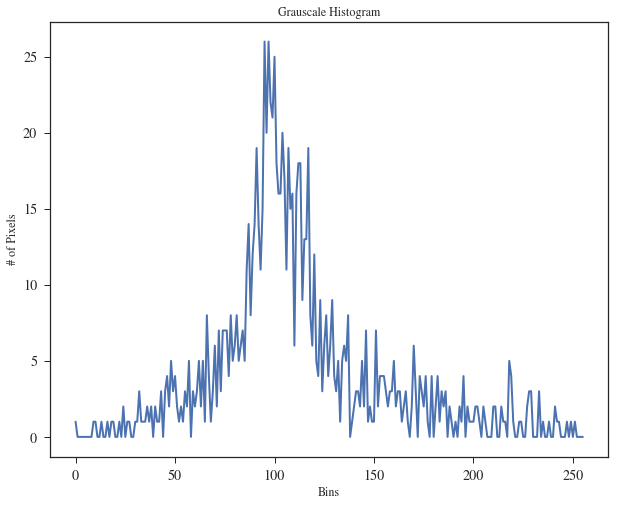

In [25]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Choose one image randomly, just to display it
batch = unpickle(DATADIR+"data_batch_1")

# For more detail on the dataset files, see http://www.cs.toronto.edu/%7Ekriz/cifar.html 
IMG_SIZE = 32 # each image in the dataset is 32*32, color
img_array = batch[b'data'][0].reshape(3, 1024)
ziplist = list(zip(img_array[2], img_array[1], img_array[0]))
newarray = np.array(ziplist).reshape(IMG_SIZE, IMG_SIZE, 3)

#plt.imshow(newarray)
#plt.show

img_array = cv2.cvtColor(newarray, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_array, cmap='gray')
#plt.show

metafile = unpickle(DATADIR+"batches.meta") 
print("This image is a", metafile[b'label_names'][batch[b'labels'][0]], ". Its label is", batch[b'labels'][0])

CATEGORIES = []
for i in range(len(metafile[b'label_names'])):
    CATEGORIES.append(metafile[b'label_names'][i])

print(len(metafile[b'label_names']), "categories:", CATEGORIES)

for batchfile in os.listdir(DATADIR):
    try:        
        if (batchfile.startswith("data_batch_") or batchfile == 'test_batch'):                
            batch = unpickle(os.path.join(DATADIR, batchfile))
            print(len(batch[b'data']), "images are in", batchfile)
            for i in range(len(batch[b'data'])): # There should be 10000 images in each batch                    
                # 1024 red values, then 1024 green values, then 1024 blue values
                img_array = batch[b'data'][i].reshape(3, 1024) 
                #print("shape is", img_array.shape)
                # Note that OpenCV needs BGR instead of RGB
                ziplist = list(zip(img_array[2], img_array[1], img_array[0])) 
                img_array = np.array(ziplist).reshape(IMG_SIZE, IMG_SIZE, 3)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                img_gray_hist = cv2.calcHist([img_array],[0],None,[256],[0,256])

                #plt.imshow(img_array,cmap='gray')
                #plt.axis('off')
                #plt.title('Grayscale Image')
                #plt.show()

                plt.plot(img_gray_hist)
                plt.title('Grauscale Histogram')
                plt.xlabel('Bins')
                plt.ylabel('# of Pixels')
                plt.show()
                
                break  
            break
    except Exception as e:
        pass#pass the image if they broken    
    


In [26]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    # if imutils.is_cv2():
    #    hist = cv2.normalize(hist)
    #print("line2")
    # otherwise, perform "in place" normalization in OpenCV 3
    #else:
    cv2.normalize(hist, hist)
    
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [27]:
rawImages = []
features = []
labels = []

def create_training_data():    
    for batchfile in os.listdir(DATADIR):        
        if (batchfile.startswith("data_batch_") or batchfile == 'test_batch'):                
            batch = unpickle(os.path.join(DATADIR, batchfile))
            print(len(batch[b'data']), "images are in", batchfile)
            for i in range(len(batch[b'data'])): # There should be 10000 images in each batch                    
                # 1024 red values, then 1024 green values, then 1024 blue values
                img_array = batch[b'data'][i].reshape(3, 1024) 
                #print("shape is", img_array.shape)
                # Note that OpenCV needs BGR instead of RGB
                ziplist = list(zip(img_array[2], img_array[1], img_array[0])) 
                img_array = np.array(ziplist).reshape(IMG_SIZE, IMG_SIZE, 3)
                pixels = image_to_feature_vector(img_array)    
                hist = extract_color_histogram(img_array)       
                label = batch[b'labels'][i]
                
                rawImages.append(pixels)
                features.append(hist)
                labels.append(label)                    
create_training_data()


10000 images are in data_batch_1
10000 images are in data_batch_2
10000 images are in data_batch_3
10000 images are in data_batch_4
10000 images are in data_batch_5
10000 images are in test_batch


In [30]:
print(len(rawImages))
print(len(features))
print(len(labels))


60000
60000
60000


In [31]:
%%time
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rawImages = pca.fit_transform(rawImages)


Wall time: 62 ms


In [32]:
rawImages.shape

(60000, 2)

In [36]:
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)

print("[INFO] pixels matrix: {:.2f}MB".format(rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 0.94MB
[INFO] features matrix: 120.00MB


In [37]:
# partition the data into training and testing splits, using 85%
# of the data for training and the remaining 15% for testing
(trainRI, testRI, trainRL, testRL) = train_test_split(rawImages, labels, test_size=0.15, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(features, labels, test_size=0.15, random_state=42)

In [ ]:
#import pickle
#dataset = {
#    'trainRI': trainRI,
#    'testRI' : testRI,
#    'trainRL': trainRL,
#    'testRL' : testRL
#}
#filename = 'rawImagesdataset.pickle'

#outfile = open(filename,'wb+')
#print(outfile)
#pickle.dump(dataset,outfile)
#outfile.close()

In [ ]:
#import pickle

#dataset = {
#    'trainFeat': trainFeat,
#    'testFeat' : testFeat,
#    'trainLabels': trainLabels,
#    'testLabels' : testLabels
#}
#filename = 'features_scaleddataset.pickle'

#outfile = open(filename,'wb+')
#print(outfile)
#pickle.dump(dataset,outfile)
#outfile.close()

In [ ]:
#import pickle

#with open('features_scaleddataset.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
 #   features_scaleddataset = pickle.load(f)
  #  f.close()
    
#(trainRI, testRI, trainRL, testRL) =   features_scaleddataset  

In [44]:
model_rgb_rf = RandomForestClassifier(n_estimators =800, max_depth =30, random_state=1234,max_features='auto',bootstrap=True)
model_rgb_rf.fit(trainFeat, trainLabels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [39]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model_rgb_rf, open(filename, 'wb'))

In [45]:
output_dir = cwd
print(labels)
print(len(trainLabels))
print(len(trainRI))
print(len(model_rgb_rf))

[6 9 9 ... 5 1 7]
51000
51000
800


In [46]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

In [47]:
cv_results = cross_validate(model_rgb_rf, testFeat, testLabels, cv=3,return_train_score=False)
sorted(cv_results.keys())                         

['fit_time', 'score_time', 'test_score']

In [48]:
cv_results['test_score']   

array([0.38348868, 0.38592395, 0.39292862])